In [41]:
## Written by Mark A. Rossi for generating heatmaps found in McHenry et al., Nat. Neurosci. 

## Takes data collected from exposure to 3 odors and compares the responses.  Intended for use with calcium imaging data. 
## Input files should be in the form of a numpy array with shape [ROIs x Total Frames] called 'extractedsignals.npy'.  
## One file per odor per subject. In order for this code to work, the ROIs must be in the same order between files.  

## NOTE: data should be organized in folders with the form:
#      ~/Experiment/Condition1/Subject1/extractedsignals.npy  
               # (e.g. extractedsignals.npy is [38 x 2000] numpy array 38 cells by 2000 frames from mouse1 for odor 1)
#      ~/Experiment/Condition1/Subject2/extractedsignals.npy
              # (e.g. extractedsignals.npy is [65 x 2000] numpy array 65 cells by 2000 frames from mouse2  for odor 1)
#      ~/Experiment/Condition2/Subject1/extractedsignals.npy
            # (e.g. extractedsignals.npy is [38 x 2000] numpy array 38 cells by 2000 frames from mouse1 for odor 2)
#      ~/Experiment/Condition2/Subject2/extractedsignals.npy
            # (e.g. extractedsignals.npy is [65 x 2000] numpy array 65 cells by 2000 frames from mouse2  for odor 2)
#      ~/Experiment/Condition3/Subject1/extractedsignals.npy
            # (e.g. extractedsignals.npy is [38 x 2000] numpy array 38 cells by 2000 frames from mouse1 for odor 3)
#      ~/Experiment/Condition3/Subject2/extractedsignals.npy
            # (e.g. extractedsignals.npy is [65 x 2000] numpy array 65 cells by 2000 frames from mouse2  for odor 3)

# and the base directories below should be set to:
#      basedir1 = ~/Experiment/Condition1
#      basedir2 = ~/Experiment/Condition2
#      basedir3 = ~/Experiment/Condition3

In [42]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from os import listdir
import csv

In [43]:
##EDIT THIS SECTION.  (See above for notes about file structure)

%cd 'C:\Users\Stuber Lab\Desktop\2p imaging\Experiment' #working directory and where files will save

basedir1 = 'C:\\Users\\Stuber Lab\\Desktop\\2p imaging\\Experiment\\condition 1'
basedir2 = 'C:\\Users\\Stuber Lab\\Desktop\\2p imaging\\Experiment\\condition 2'
basedir3 = 'C:\\Users\\Stuber Lab\\Desktop\\2p imaging\\Experiment\\condition 3'

filename='Stuber_lab_Experiment1_test'  #Name to be appended to saved files  as an identifier

condition = ['Odor1','Odor2','Odor2']   #Change these to be your three specific odors

maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
maxframes=2000 #should be the total frames

[Error 123] The filename, directory name, or volume label syntax is incorrect: u"'C:/Users/Stuber Lab/Desktop/2p imaging/Experiment' #directories where files will save"
C:\Users\Stuber Lab\Desktop\2p imaging\Jenna code\final codes for github\test files


In [44]:
## EDIT HERE ##

framerate=5          #frames/s for acquisition
numtrials=7          #Number of trials
baseline_dur=10      #how long is baseline (in seconds)
stimulus_dur=10      #how long is stimulus window (in seconds)
trial_length=40      #how long is each trial (in seconds)

test_type='wilcoxon' # type of t-test ('independent','paired', or 'wilcoxon')
sig_pvalue=0.05      #p-value (two-tailed) to consider significant

baseline=[0,50]      # Frames considered'baseline' epoch
test=[50,75]         # Frames considered 'odor' epoch
    
## normalize data by baseline?
normalize_on=['yes']

## Save Figures?
save_figs=['yes']

## Save data files?
save_files=['yes']

##trials to use for analysis (0 is trial 1, numtrials-1=last trial)
included_trials=[0,7]

## TIL HERE ##

In [45]:
numpreframes=framerate*baseline_dur #How long is the baseline period (per trial)
numtestframes=framerate*stimulus_dur #How long is the stimulus presented (per trial)?
numframespertrial=framerate*trial_length #How long is each trial

In [46]:
## Load files in basedir1 and basedir2
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxnumneurons,maxframes))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(directory,data_dir,'extractedsignals.npy'))
        numneurons=signals.shape[1]
        numframes=signals.shape[2]
        temp_signals=np.squeeze(signals)
        for a in range(0,numneurons):
            signals_pop[numneuronstillnow+a,0:signals.shape[2]]=temp_signals[a,:]
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:numneuronstillnow,:]
    print 'files = '+str(data_dirs)
    print 'Number of neurons = '+str(extractedsignals.shape[0])
    print ' '
    return extractedsignals,numneuronstillnow,numframes,numneurons
extractedsignals1,numneuronstillnow,numframes,numneurons=load_files(basedir1)
extractedsignals2,numneuronstillnow,numframes,numneurons=load_files(basedir2)
extractedsignals3,numneuronstillnow,numframes,numneurons=load_files(basedir3)

StopIteration: 

In [9]:
## reshape data into trial structure
def reshape_data(data):
    numtrials=data.shape[1]/numframespertrial
    numneurons=data.shape[0]
    numframes=data.shape[1]
    stimstartframes=np.nan*np.zeros((numtrials,1))
    for a in range(0,numtrials):
        stimstartframes[a] = numpreframes + (numframespertrial*a)
    reshape_response=data
    reshape_response=np.reshape(reshape_response, [numneurons,numframespertrial,numtrials],order='F')
    reshape_response=reshape_response[:,:,included_trials[0]:included_trials[1]]
    return reshape_response

reshape1=reshape_data(extractedsignals1)
reshape2=reshape_data(extractedsignals2)
reshape3=reshape_data(extractedsignals3)
numtrials=included_trials[1]-included_trials[0]

In [10]:
#normalize data by baseline period
if normalize_on[0]=='yes':
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]/BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    reshape1_norm=normalize_data(reshape1)
    reshape2_norm=normalize_data(reshape2)
    reshape3_norm=normalize_data(reshape3)
else:
    reshape1_norm=reshape1
    reshape2_norm=reshape2
    reshape3_norm=reshape3

In [11]:
print 'Number of trials included = '+str(reshape1_norm.shape[2])

Number of trials included = 7


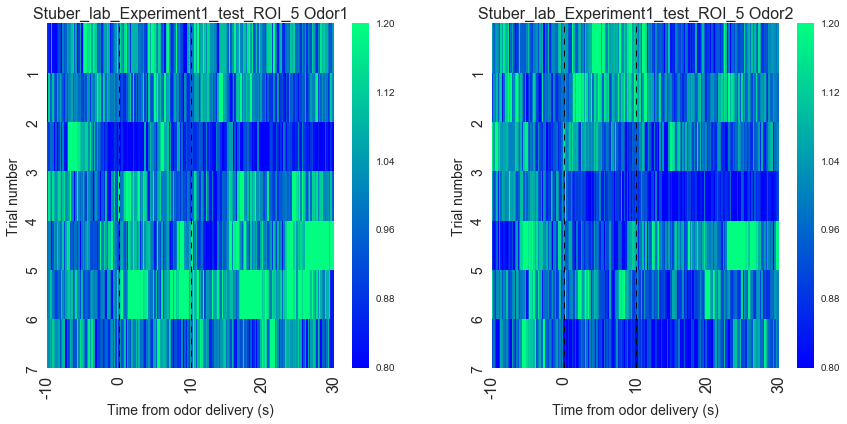

In [47]:
##plot all trials for individual neurons

neuron=5 #Define which neuron you want to plot

fig20 = plt.subplots(1,2,figsize=(12,6))
ax=plt.subplot(121)
sns.heatmap(reshape1_norm[neuron,:,:].T, linewidth=0, cmap='winter', vmin=.8, vmax=1.2)
ax.grid(b=False)
ax.set_title(filename+'_ROI_'+str(neuron)+' '+str(condition[0]), fontsize='16')
ax.set_xlabel('Time from odor delivery (s)',fontsize='14')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
ax.set_yticks(range(0,numtrials, 1))
ax.set_yticklabels([str(a) for a in range(numtrials,0,-1)],fontsize='14')
ax.plot([numpreframes, numpreframes], [0, numtrials], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,numtrials], '--k', linewidth=1)
ax.set_ylabel('Trial number',fontsize='14')

ax=plt.subplot(122)
sns.heatmap(reshape2_norm[neuron,:,:].T, linewidth=0, cmap='winter', vmin=.8, vmax=1.2)
ax.grid(b=False)
ax.set_title(filename+'_ROI_'+str(neuron)+' '+str(condition[1]), fontsize='16')
ax.set_xlabel('Time from odor delivery (s)',fontsize='14')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
ax.set_yticks(range(0, numtrials, 1))
ax.set_yticklabels([str(a) for a in range(numtrials,0,-1)],fontsize='14')
ax.plot([numpreframes, numpreframes], [0, numtrials], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,numtrials], '--k', linewidth=1)
ax.set_ylabel('Trial number',fontsize='14')
if save_figs[0]=='yes':plt.savefig(filename+'_ROI_'+str(neuron)+'.pdf', fmt='pdf')
plt.tight_layout(w_pad=5)
plt.show()

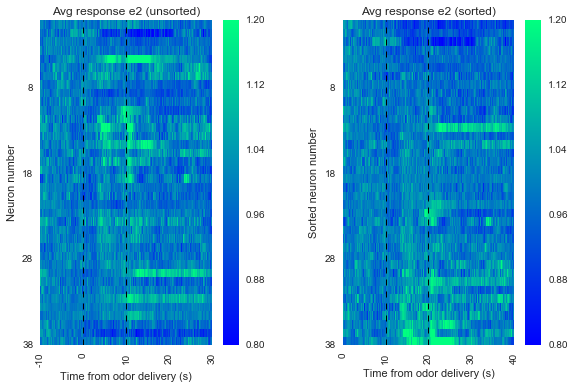

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


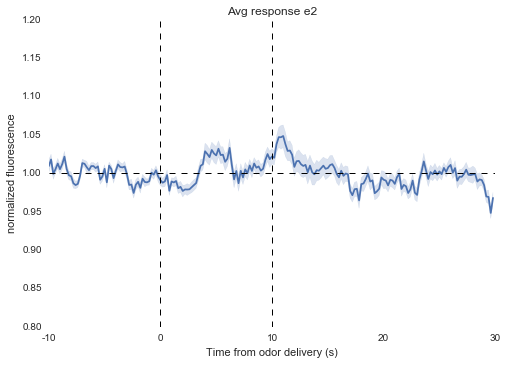

In [13]:
## Plot avg responses for condition1
avgresponse1=np.mean(reshape1_norm, axis=2)
fig1= plt.figure(1)
ax=plt.subplot(121)
sortedneurons=np.argsort(np.mean(avgresponse1[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse1, cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2,center=1, linewidth=0)
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[0])+' (unsorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0, -10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig1.tight_layout()

fig2 = plt.figure(1)
ax=plt.subplot(122)
sortedneurons=np.argsort(np.mean(avgresponse1[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse1[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[0])+' (sorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Sorted neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(0, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0,-10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig2.tight_layout(w_pad=5)
plt.show()
if save_figs[0]=='yes': 
    fig2.savefig(filename+'_heatmap_'+str(condition[0])+'.pdf',fmt='pdf')

fig3,ax3 = plt.subplots(1)
sns.tsplot(avgresponse1)
ax3.set_title('Avg response '+str(condition[0]))
ax3.set_xlabel('Time from odor delivery (s)')
ax3.set_ylabel('normalized fluorescence')
ax3.set_xticks(range(0, numframespertrial+1, 50))
ax3.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframes+1, 50)])
ax3.set_axis_bgcolor('white')
ax3.plot([numpreframes, numpreframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([numpreframes+numtestframes, numpreframes+numtestframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([0, numframespertrial], [1, 1], '--k', linewidth=1)
plt.show()
if save_figs[0]=='yes': 
    fig3.savefig(filename+'_mean_response_'+str(condition[0])+'.pdf',fmt='pdf')

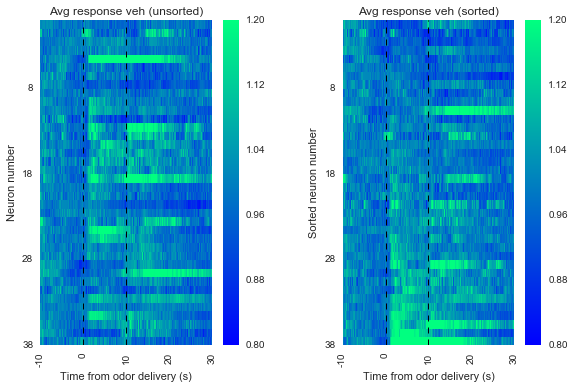

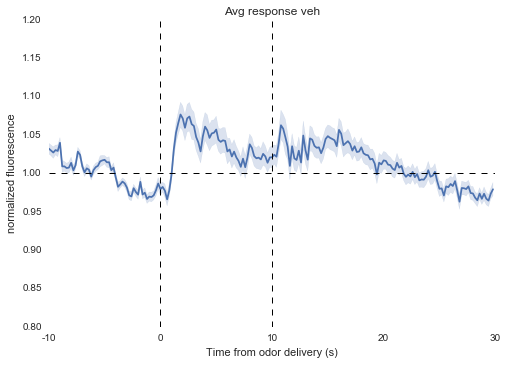

In [14]:
## Plot avg responses for condition2
avgresponse2=np.mean(reshape2_norm, axis=2)
fig4= plt.figure(1)
ax=plt.subplot(121)
sortedneurons=np.argsort(np.mean(avgresponse2[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse2, cmap=plt.get_cmap('winter'),linewidth=0, vmin=.8, vmax=1.2,center=1, )
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[1])+' (unsorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0,-10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig4.tight_layout()

fig5 = plt.figure(1)
ax=plt.subplot(122)
sortedneurons=np.argsort(np.mean(avgresponse2[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse2[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[1])+' (sorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Sorted neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0,-10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig5.tight_layout(w_pad=5)
plt.show()
if save_figs[0]=='yes':
    fig5.savefig(filename+'_heatmap_'+str(condition[1])+'.pdf',fmt='pdf')

fig6,ax3 = plt.subplots(1)
sns.tsplot(avgresponse2)
ax3.set_title('Avg response '+str(condition[1]))
ax3.set_xlabel('Time from odor delivery (s)')
ax3.set_ylabel('normalized fluorescence')
ax3.set_xticks(range(0, numframespertrial+1, 50))
ax3.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframes+1,50)])
ax3.set_axis_bgcolor('white')
ax3.plot([numpreframes, numpreframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([numpreframes+numtestframes, numpreframes+numtestframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([0, numframespertrial], [1, 1], '--k', linewidth=1)
plt.show()
if save_figs[0]=='yes':
    fig6.savefig(filename+'_avg_response_'+str(condition[1])+'.pdf',fmt='pdf')

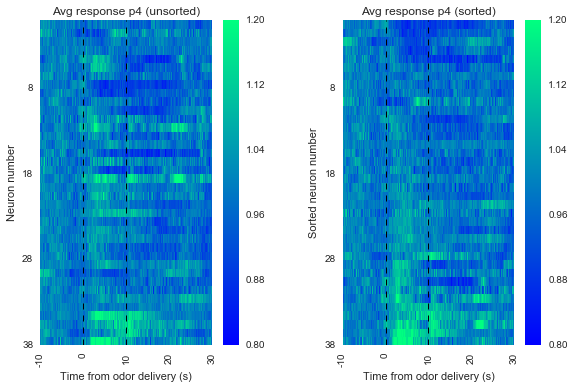

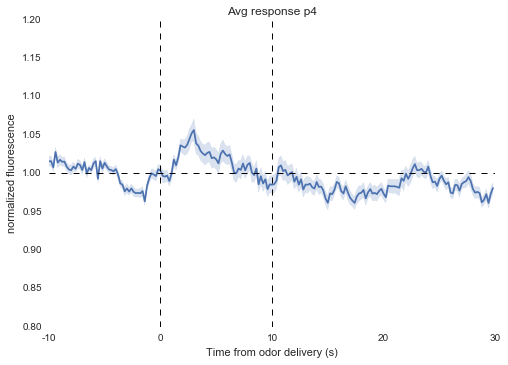

In [15]:
## Plot avg responses for condition3
avgresponse3=np.mean(reshape3_norm, axis=2)
fig4= plt.figure(1)
ax=plt.subplot(121)
sortedneurons=np.argsort(np.mean(avgresponse3[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse3, cmap=plt.get_cmap('winter'),linewidth=0, vmin=.8, vmax=1.2,center=1, )
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[2])+' (unsorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0,-10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig4.tight_layout()

fig5 = plt.figure(1)
ax=plt.subplot(122)
sortedneurons=np.argsort(np.mean(avgresponse3[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse3[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[2])+' (sorted)')
ax.set_xlabel('Time from odor delivery (s)')
ax.set_ylabel('Sorted neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0,-10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)
fig5.tight_layout(w_pad=5)
plt.show()
if save_figs[0]=='yes':
    fig5.savefig(filename+'_heatmap_'+str(condition[2])+'.pdf',fmt='pdf')

fig6,ax3 = plt.subplots(1)
sns.tsplot(avgresponse3)
ax3.set_title('Avg response '+str(condition[2]))
ax3.set_xlabel('Time from odor delivery (s)')
ax3.set_ylabel('normalized fluorescence')
ax3.set_xticks(range(0, numframespertrial+1, 50))
ax3.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframes+1,50)])
ax3.set_axis_bgcolor('white')
ax3.plot([numpreframes, numpreframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([numpreframes+numtestframes, numpreframes+numtestframes], [.8, 1.2], '--k', linewidth=1)
ax3.plot([0, numframespertrial], [1, 1], '--k', linewidth=1)
plt.show()
if save_figs[0]=='yes':
    fig6.savefig(filename+'_avg_response_'+str(condition[2])+'.pdf',fmt='pdf')


In [16]:
##Determine significantly excited and inhibited neurons using type of test defined above
def find_sig(data,avgresponse,condition):
    stimulusresponse=np.nan*np.zeros((numneuronstillnow,numtrials,2))
    testsig_ind=np.zeros((numneuronstillnow,2))
    testsig_paired=np.zeros((numneuronstillnow,2))
    for a in range(0,numneuronstillnow):
        for b in range(0,numtrials):
            stimulusresponse[a,b,0]=np.nanmean(data[a,test[0]:test[1],b])
            stimulusresponse[a,b,1]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        if test_type=='independent':
            testsig_paired[a,:]=stats.ttest_ind(stimulusresponse[a,:,0],stimulusresponse[a,:,1],equal_var=False)
        if test_type=='paired':
            testsig_paired[a,:]=stats.ttest_rel(stimulusresponse[a,:,0],stimulusresponse[a,:,1])
        if test_type=='wilcoxon':
            testsig_paired[a,:]=stats.wilcoxon(stimulusresponse[a,:,0],stimulusresponse[a,:,1],zero_method='wilcox')
    sig_excited_neurons=np.zeros((numneuronstillnow,1));sig_excited_neurons[:]=np.nan
    sig_inhibited_neurons=np.zeros((numneuronstillnow,1));sig_inhibited_neurons[:]=np.nan
    if test_type=='wilcoxon':
        for a in range(0,numneuronstillnow):
            sig_excited_neurons[a,:] = np.logical_and(testsig_paired[a,1]<sig_pvalue,np.nanmean(stimulusresponse[a,:,0],axis=0)>np.nanmean(stimulusresponse[a,:,1],axis=0))
            sig_inhibited_neurons[a,:] = np.logical_and(testsig_paired[a,1]<sig_pvalue,np.nanmean(stimulusresponse[a,:,0],axis=0)<np.nanmean(stimulusresponse[a,:,1],axis=0))
    else:
        sig_excited_neurons = np.logical_and(testsig_paired[:,0]>0,testsig_paired[:,1]<sig_pvalue)    
        sig_inhibited_neurons = np.logical_and(testsig_paired[:,0]<0,testsig_paired[:,1]<sig_pvalue)
    print 'Test type = '+test_type
    print 'Condition = '+condition
    print 'p-value = '+str(sig_pvalue)
    print 'number of sig EXCITED cells = '+str(np.sum(sig_excited_neurons))
    print 'number of sig INHIBITED cells = '+str(np.sum(sig_inhibited_neurons))
    print '  '
    
    ind_sig_inhibited=sig_inhibited_neurons*1
    ind_sig_excited=sig_excited_neurons*1
    roinumber=np.arange(1,numneuronstillnow+1)
    ind_sig_inhibited=np.squeeze(ind_sig_inhibited)
    ind_sig_excited=np.squeeze(ind_sig_excited)
    ind_sig_inhibited=np.vstack((roinumber,ind_sig_inhibited))
    ind_sig_excited=np.vstack((roinumber,ind_sig_excited))
    count_sig_inhibited_neurons=np.zeros((numneuronstillnow,1));count_sig_inhibited_neurons[:]=np.nan
    count_sig_excited_neurons=np.zeros((numneuronstillnow,1));count_sig_excited_neurons[:]=np.nan

    for a in range(0,numneuronstillnow):
        if ind_sig_inhibited[1,a]>0:
            count_sig_inhibited_neurons[a,:]=ind_sig_inhibited[0,a]
        if ind_sig_excited[1,a]>0:
            count_sig_excited_neurons[a,:]=ind_sig_excited[0,a]

    count_sig_inhibited_neurons=count_sig_inhibited_neurons[~np.isnan(count_sig_inhibited_neurons)]
    count_sig_excited_neurons=count_sig_excited_neurons[~np.isnan(count_sig_excited_neurons)]
    find_sig_excited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_excited_neurons[:]=np.nan
    find_sig_inhibited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_inhibited_neurons[:]=np.nan
    find_sig_neurons=np.zeros(avgresponse.shape);find_sig_neurons[:]=np.nan
    for a in range(0,numneuronstillnow):
        if sig_excited_neurons[a]==True:
            find_sig_excited_neurons[a,:]=avgresponse[a,:]
        if sig_inhibited_neurons[a]==True:
            find_sig_inhibited_neurons[a,:]=avgresponse[a,:]  

    mask_excited = np.all(np.isnan(find_sig_excited_neurons) | np.equal(find_sig_excited_neurons, 0), axis=1)
    plot_sig_excited_neurons=find_sig_excited_neurons[~mask_excited]
    mask_inhibited = np.all(np.isnan(find_sig_inhibited_neurons) | np.equal(find_sig_inhibited_neurons, 0), axis=1)
    plot_sig_inhibited_neurons=find_sig_inhibited_neurons[~mask_inhibited]
    peakresponse=np.zeros((numneuronstillnow,numtrials));peakresponse[:]=np.nan
    for a in range(0,numneuronstillnow):
        for b in range(0,numtrials):
            peakresponse[a,b]=np.max(data[a,test[0]:test[1],b])
    np.savetxt(filename+'_Peak_Response'+condition+'.csv', peakresponse,delimiter=',')
    return count_sig_excited_neurons,plot_sig_excited_neurons,count_sig_inhibited_neurons,plot_sig_inhibited_neurons,peakresponse,mask_excited

count_sig_excited_neurons1,plot_sig_excited_neurons1,count_sig_inhibited_neurons1,plot_sig_inhibited_neurons1,peakresponse1,mask_excited1=find_sig(reshape1_norm,avgresponse1,condition=condition[0])
count_sig_excited_neurons2,plot_sig_excited_neurons2,count_sig_inhibited_neurons2,plot_sig_inhibited_neurons2,peakresponse2,mask_excited2=find_sig(reshape2_norm,avgresponse2,condition=condition[1])
count_sig_excited_neurons3,plot_sig_excited_neurons3,count_sig_inhibited_neurons3,plot_sig_inhibited_neurons3,peakresponse3,mask_excited3=find_sig(reshape3_norm,avgresponse3,condition=condition[2])

Test type = wilcoxon
Condition = e2
p-value = 0.5
number of sig EXCITED cells = 7.0
number of sig INHIBITED cells = 17.0
  
Test type = wilcoxon
Condition = veh
p-value = 0.5
number of sig EXCITED cells = 19.0
number of sig INHIBITED cells = 5.0
  
Test type = wilcoxon
Condition = p4
p-value = 0.5
number of sig EXCITED cells = 20.0
number of sig INHIBITED cells = 9.0
  


C:\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1967: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


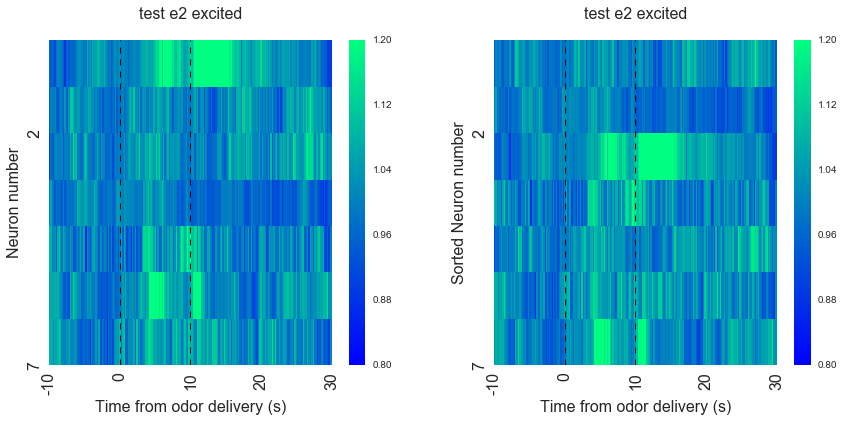

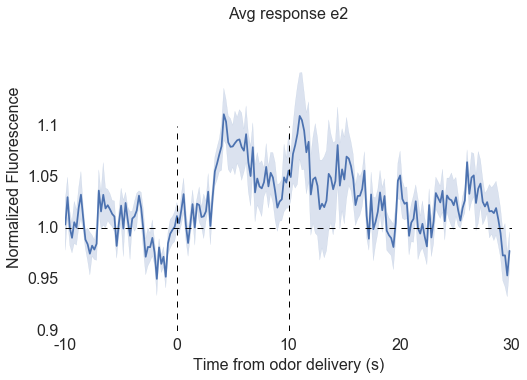

In [17]:
##Plot population data Excited condition 1
def plotlickresponse_pop(data,condition,title,heatmap_min,heatmap_max,totalrois,ts_min,ts_max):
    fig = plt.subplots(1,2,figsize=(12,6))
    ax1=plt.subplot(121)
    sns.heatmap(data,cmap='winter',vmin=heatmap_min,vmax=heatmap_max,linewidths=0)
    ax1.grid(b=False)
    ax1.set_title(title,fontsize='16',y=1.05)
    ax1.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax1.set_ylabel('Neuron number',fontsize='16')
    ax1.set_xticks(range(0, numframespertrial+1, 50))
    ax1.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax1.set_yticks(range(0, totalrois, 5))
    ax1.set_yticklabels([str(a) for a in range(totalrois,0,-5)],fontsize='16')
    ax1.plot([numpreframes, numpreframes], [0, totalrois], '--k', linewidth=1)
    ax1.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,totalrois], '--k', linewidth=1)
  
    ax2=plt.subplot(122)
    sortneurons = np.argsort(np.mean(data[:numneuronstillnow,test[0]:test[1]], axis=1))
    sns.heatmap(data[sortneurons,:],cmap='winter',vmin=heatmap_min,vmax=heatmap_max,linewidths=0)
    ax2.grid(b=False)
    ax2.set_title(title,fontsize='16',y=1.05)
    ax2.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax2.set_ylabel('Sorted Neuron number',fontsize='16')
    ax2.set_xticks(range(0, numframespertrial+1, 50))
    ax2.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax2.set_yticks(range(0, totalrois, 5))
    ax2.set_yticklabels([str(a) for a in range(totalrois,0,-5)],fontsize='16')
    ax2.plot([numpreframes, numpreframes], [0, totalrois], '--k', linewidth=1)
    ax2.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,totalrois], '--k', linewidth=1)
    ax2.grid(False)
    plt.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(title+' heatmap_excited.pdf', format='pdf')
    
    fig_ts,ax3 = plt.subplots(1)
    sns.tsplot(data[sortneurons,:])
    ax3.set_title('Avg response '+condition,fontsize='16')
    ax3.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax3.set_ylabel('Normalized Fluorescence',fontsize='16')
    ax3.set_yticklabels([str(a) for a in np.arange(ts_min, ts_max, .05)],fontsize='16')
    ax3.set_axis_bgcolor('white')
    ax3.set_xticks(range(0, numframespertrial+1, 50))
    ax3.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax3.plot([numpreframes, numpreframes], [ts_min,ts_max], '--k', linewidth=1)
    ax3.plot([numpreframes+numtestframes, numpreframes+numtestframes], [ts_min,ts_max], '--k', linewidth=1)
    ax3.plot([0, numframespertrial], [1, 1], '--k', linewidth=1)
    if save_figs[0]=='yes':
        plt.savefig(title+' AVG_excited.pdf', format='pdf')
    plt.show()
    return fig_ts

fig7 = plotlickresponse_pop(condition=condition[0],title=filename+' '+condition[0]+' excited', data=plot_sig_excited_neurons1,
                            heatmap_min=0.8,heatmap_max=1.2,ts_min=0.9,ts_max=1.1,totalrois=len(count_sig_excited_neurons1))

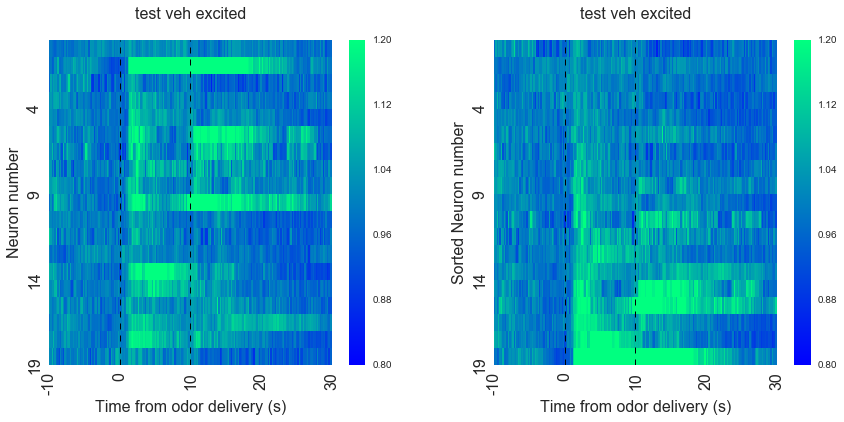

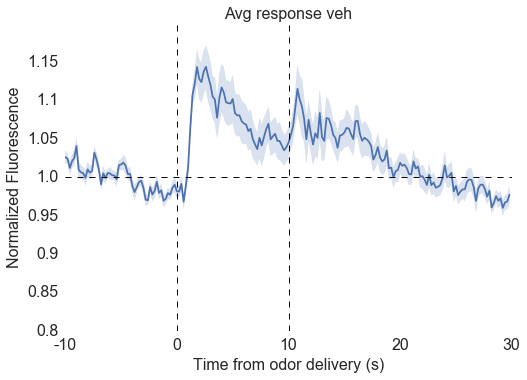

In [18]:
##plot sig excited neurons condition 2
fig8 = plotlickresponse_pop(condition=condition[1],title=filename+' '+condition[1]+' excited', data=plot_sig_excited_neurons2,
                            heatmap_min=0.8,heatmap_max=1.2,ts_min=0.8,ts_max=1.2,totalrois=len(count_sig_excited_neurons2))

In [ ]:
##plot sig excited neurons condition 3
fig9 = plotlickresponse_pop(condition=condition[2],title=filename+' '+condition[2]+' excited', data=plot_sig_excited_neurons3,
                            heatmap_min=0.8,heatmap_max=1.2,ts_min=0.8,ts_max=1.2,totalrois=len(count_sig_excited_neurons3))

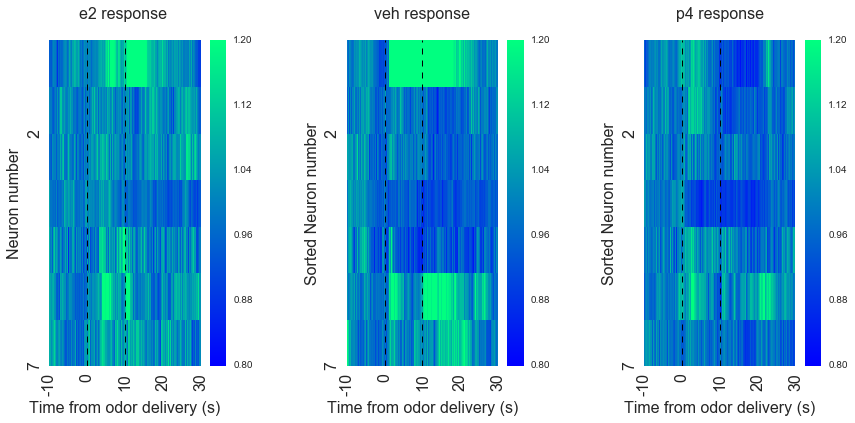

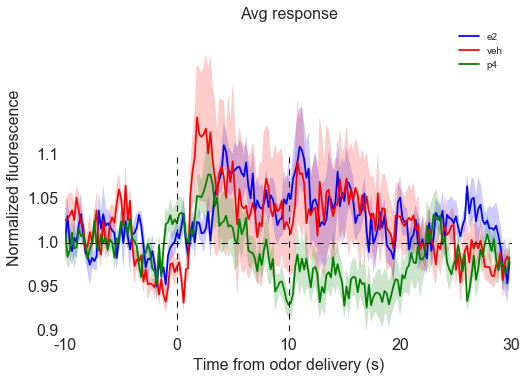

In [19]:
## plot signifiant responders on condition 1 responses to condition 2 and 3
plot_sig_excited_neurons2_cond1=reshape2_norm[~mask_excited1]
plot_sig_excited_neurons3_cond1=reshape3_norm[~mask_excited1]
avg_sig_cond1_response_to_cond2=np.nanmean(plot_sig_excited_neurons2_cond1,axis=2)
avg_sig_cond1_response_to_cond3=np.nanmean(plot_sig_excited_neurons3_cond1,axis=2)

#Plot population data Male Excited
def plotlickresponse_pop_compare(data,data2,data3,title,heatmap_min,heatmap_max,totalrois,ts_min,ts_max):
    fig = plt.subplots(1,2,figsize=(12,6))
    ax1=plt.subplot(131)
    sns.heatmap(data,cmap='winter',vmin=heatmap_min,vmax=heatmap_max,linewidths=0)
    ax1.grid(b=False)
    ax1.set_title(str(condition[0])+' response ',fontsize='16',y=1.05)
    ax1.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax1.set_ylabel('Neuron number',fontsize='16')
    ax1.set_xticks(range(0, numframespertrial+1, 50))
    ax1.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax1.set_yticks(range(0, totalrois, 5))
    ax1.set_yticklabels([str(a) for a in range(totalrois,0,-5)],fontsize='16')
    ax1.plot([numpreframes, numpreframes], [0, totalrois], '--k', linewidth=1)
    ax1.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,totalrois], '--k', linewidth=1)
  
    ax2=plt.subplot(132)
    sns.heatmap(data2,cmap='winter',vmin=heatmap_min,vmax=heatmap_max,linewidths=0)
    ax2.grid(b=False)
    ax2.set_title(str(condition[1])+' response',fontsize='16',y=1.05)
    ax2.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax2.set_ylabel('Sorted Neuron number',fontsize='16')
    ax2.set_xticks(range(0, numframespertrial+1, 50))
    ax2.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax2.set_yticks(range(0, totalrois, 5))
    ax2.set_yticklabels([str(a) for a in range(totalrois,0,-5)],fontsize='16')
    ax2.plot([numpreframes, numpreframes], [0, totalrois], '--k', linewidth=1)
    ax2.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,totalrois], '--k', linewidth=1)
    ax2.grid(False)
    plt.tight_layout(w_pad=5)
    
    ax2=plt.subplot(133)
    sns.heatmap(data3,cmap='winter',vmin=heatmap_min,vmax=heatmap_max,linewidths=0)
    ax2.grid(b=False)
    ax2.set_title(str(condition[2])+' response',fontsize='16',y=1.05)
    ax2.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax2.set_ylabel('Sorted Neuron number',fontsize='16')
    ax2.set_xticks(range(0, numframespertrial+1, 50))
    ax2.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax2.set_yticks(range(0, totalrois, 5))
    ax2.set_yticklabels([str(a) for a in range(totalrois,0,-5)],fontsize='16')
    ax2.plot([numpreframes, numpreframes], [0, totalrois], '--k', linewidth=1)
    ax2.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0,totalrois], '--k', linewidth=1)
    ax2.grid(False)
    plt.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(title+' heatmap.pdf', format='pdf')
    
    fig_ts,ax3 = plt.subplots(1)
    sns.tsplot(data,color='b',condition=condition[0],legend=True)
    sns.tsplot(data2,color='r',condition=condition[1],legend=True)
    sns.tsplot(data3,color='g',condition=condition[2],legend=True)
    ax3.set_title('Avg response',fontsize='16')
    ax3.set_xlabel('Time from odor delivery (s)',fontsize='16')
    ax3.set_ylabel('Normalized fluorescence',fontsize='16')
    ax3.set_yticklabels([str(a) for a in np.arange(ts_min, ts_max, .05)],fontsize='16')
    ax3.set_axis_bgcolor('white')
    ax3.set_xticks(range(0, numframespertrial+1, 50))
    ax3.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)],fontsize='16')
    ax3.plot([numpreframes, numpreframes], [ts_min,ts_max], '--k', linewidth=1)
    ax3.plot([numpreframes+numtestframes, numpreframes+numtestframes], [ts_min,ts_max], '--k', linewidth=1)
    ax3.plot([0, numframespertrial], [1, 1], '--k', linewidth=1)
    if save_figs[0]=='yes':
        plt.savefig(title+' AVG.pdf', format='pdf')
    if save_files[0]=='yes':
        np.savetxt(filename+str(' '+condition[0])+'_data.csv', data.T,delimiter=',')
        np.savetxt(filename+str(' '+condition[1])+'_data.csv', data2.T,delimiter=',')
        np.savetxt(filename+str(' '+condition[2])+'_data.csv', data3.T,delimiter=',')
    plt.show()
    return fig_ts

fig999 = plotlickresponse_pop_compare(title=filename+'_compare odor response', data=plot_sig_excited_neurons1,
                                      data2=avg_sig_cond1_response_to_cond2,data3=avg_sig_cond1_response_to_cond3,
                                      heatmap_min=0.8,heatmap_max=1.2,ts_min=0.9,ts_max=1.1,totalrois=len(count_sig_excited_neurons1))

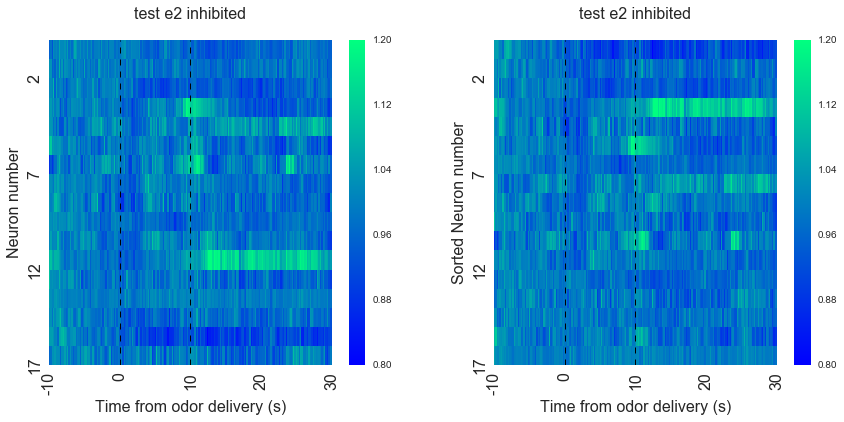

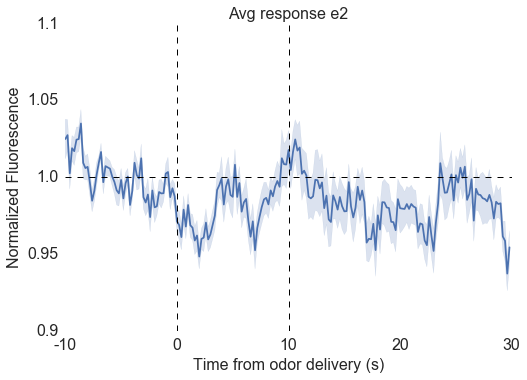

In [20]:
##plot sig inhibited cells condition1
fig10 = plotlickresponse_pop(condition=condition[0],title=filename+' '+condition[0]+' inhibited', data=plot_sig_inhibited_neurons1,
                            heatmap_min=0.8,heatmap_max=1.2,ts_min=0.9,ts_max=1.1,totalrois=len(count_sig_inhibited_neurons1))

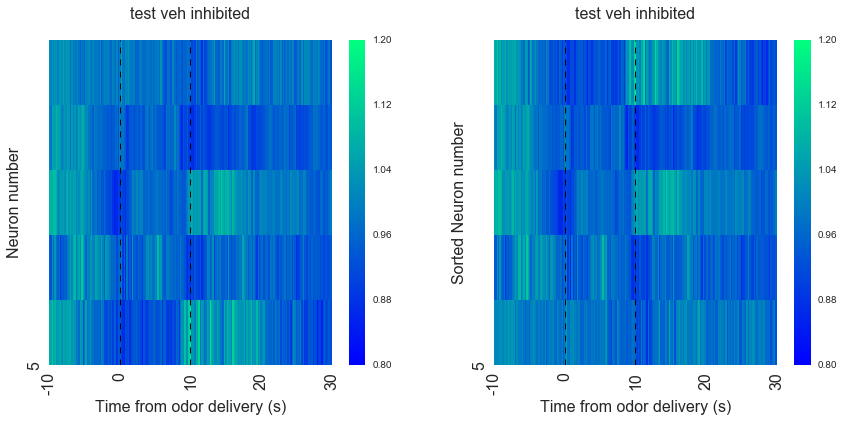

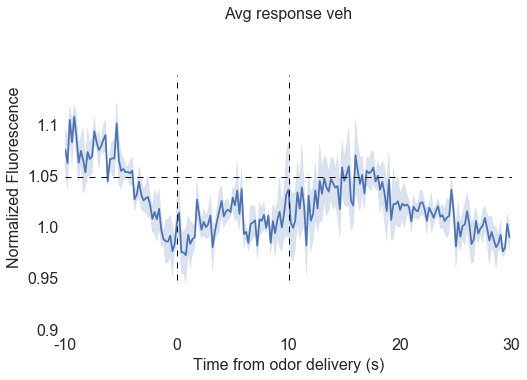

In [21]:
##plot sig inhibited cells condition 2
fig11 = plotlickresponse_pop(condition=condition[1],title=filename+' '+condition[1]+' inhibited', data=plot_sig_inhibited_neurons2,
                             heatmap_min=0.8,heatmap_max=1.2,ts_min=0.9,ts_max=1.1,totalrois=len(count_sig_inhibited_neurons2))

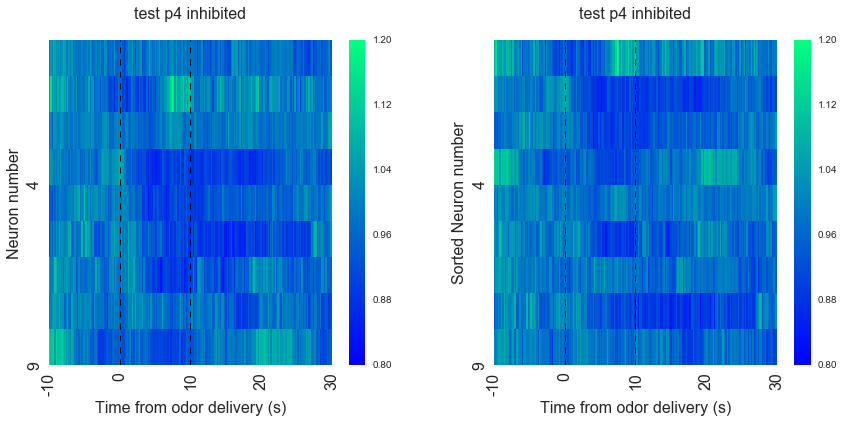

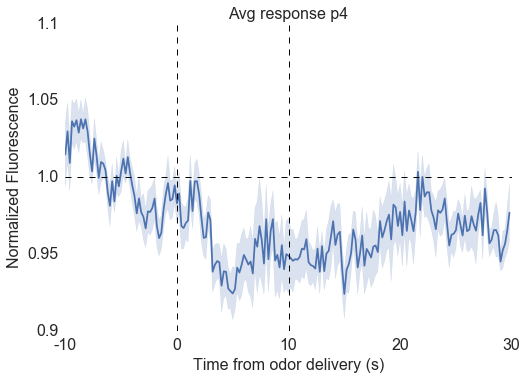

In [22]:
##plot sig inhibited cells condition 3
fig12 = plotlickresponse_pop(condition=condition[2],title=filename+' '+condition[2]+' inhibited', data=plot_sig_inhibited_neurons3,
                             heatmap_min=0.8,heatmap_max=1.2,ts_min=0.9,ts_max=1.1,totalrois=len(count_sig_inhibited_neurons3))

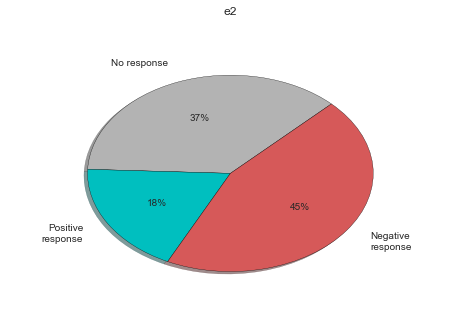

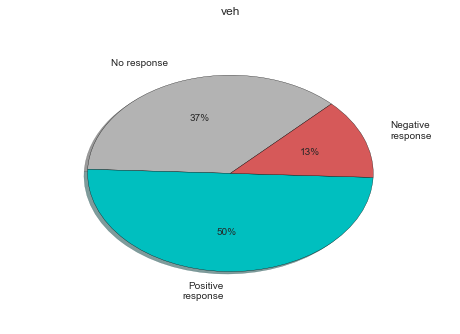

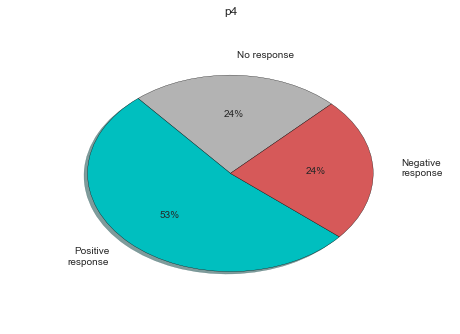

In [23]:
##plot pie chart of responses
def population_pie(excitedcount,inhibitedcount,title):
    frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
    positiveresponders = len(excitedcount)
    negativeresponders = len(inhibitedcount)
    noresponders = numneuronstillnow-(positiveresponders+negativeresponders)
    frequency_response = np.array([noresponders, positiveresponders, negativeresponders])
    frequency_population[:,0] = frequency_response
    fig,ax=plt.subplots(1)
    ax.set_title(title, y=1)
    ax.pie(frequency_response, autopct='%1.0f%%', shadow=True, startangle=45, 
           colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)],
           labels=['No response', 'Positive\nresponse', 'Negative\nresponse'],
           radius=.8,labeldistance=1.2)
    if save_figs[0]=='yes':
        plt.savefig(title+' pie.pdf', format='pdf')
    return fig

piefig1=population_pie(count_sig_excited_neurons1,count_sig_inhibited_neurons1,condition[0])
piefig2=population_pie(count_sig_excited_neurons2,count_sig_inhibited_neurons2,condition[1])
piefig3=population_pie(count_sig_excited_neurons3,count_sig_inhibited_neurons3,condition[2])

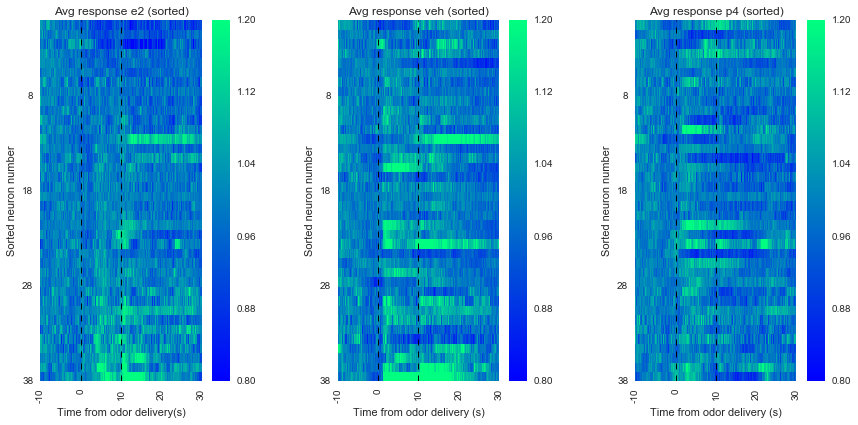

In [27]:
## Plot response of ALL NEURONS to conditions 2 and 3 odors based on response to condition1
fig11 = plt.subplots(1,figsize=(12,6))
ax=plt.subplot(131)
sortedneurons=np.argsort(np.mean(avgresponse1[:,numpreframes:numtestframes+numtestframes], axis=1))
sns.heatmap(avgresponse1[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax.grid(b=False)
ax.set_title('Avg response '+str(condition[0])+' (sorted)')
ax.set_xlabel('Time from odor delivery(s)')
ax.set_ylabel('Sorted neuron number')
ax.set_xticks(range(0, numframespertrial+1, 50))
ax.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax.set_yticks(range(0, numneuronstillnow, 10))
ax.set_yticklabels([str(a) for a in range(numneuronstillnow,0, -10)])
ax.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)

ax2=plt.subplot(132)
sns.heatmap(avgresponse2[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax2.grid(b=False)
ax2.set_title('Avg response '+str(condition[1])+' (sorted)')
ax2.set_xlabel('Time from odor delivery (s)')
ax2.set_ylabel('Sorted neuron number')
ax2.set_xticks(range(0, numframespertrial+1, 50))
ax2.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax2.set_yticks(range(0, numneuronstillnow, 10))
ax2.set_yticklabels([str(a) for a in range(numneuronstillnow,0, -10)])
ax2.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax2.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)

ax2=plt.subplot(133)
sns.heatmap(avgresponse3[sortedneurons,:], cmap=plt.get_cmap('winter'), vmin=.8, vmax=1.2, center=1, linewidth=0)
ax2.grid(b=False)
ax2.set_title('Avg response '+str(condition[2])+' (sorted)')
ax2.set_xlabel('Time from odor delivery (s)')
ax2.set_ylabel('Sorted neuron number')
ax2.set_xticks(range(0, numframespertrial+1, 50))
ax2.set_xticklabels([str(int(a/framerate)) for a in range(-50, numframespertrial+1, 50)])
ax2.set_yticks(range(0, numneuronstillnow, 10))
ax2.set_yticklabels([str(a) for a in range(numneuronstillnow,0, -10)])
ax2.plot([numpreframes, numpreframes], [0, numneuronstillnow], '--k', linewidth=1)
ax2.plot([numpreframes+numtestframes, numpreframes+numtestframes], [0, numneuronstillnow], '--k', linewidth=1)

ax2.grid(False)
plt.tight_layout(w_pad=5)
if save_figs[0]=='yes':
    plt.savefig(filename+'_Heatmap_compare_conditions_all_cells.pdf',fmt='pdf')

In [40]:
# save average response during odor epoch
avg_condtion1=np.nanmean(avgresponse1[:,test[0]:test[1]], axis=1)
avg_condtion2=np.nanmean(avgresponse2[:,test[0]:test[1]], axis=1)
avg_condtion3=np.nanmean(avgresponse3[:,test[0]:test[1]], axis=1)
np.savetxt(filename+str(' '+condition[0])+'_Avg_response.csv',avg_condtion1,delimiter=',')
np.savetxt(filename+str(' '+condition[1])+'_Avg_response.csv',avg_condtion2,delimiter=',')
np.savetxt(filename+str(' '+condition[2])+'_Avg_response.csv',avg_condtion3,delimiter=',')

In [36]:
##  save data files
def save_excited_data(condition):
    if eval(str('plot_sig_excited_neurons'+condition)).shape[0]>0:
        np.save(filename+'_Excited_ROI_nums_'+condition, 
                eval(str('count_sig_excited_neurons'+condition)))
        np.save(filename+'_excited_vals_'+condition, 
                eval(str('plot_sig_excited_neurons'+condition)))
        np.savetxt(filename+'_Excited_ROI_numbers_'+condition+'.csv', 
                eval(str('count_sig_excited_neurons'+condition)), delimiter=',',fmt='%i')
def save_inhibited_data(condition):
    if eval(str('plot_sig_inhibited_neurons'+condition)).shape[0]>0:
        np.save(filename+'_Inhibited_ROI_nums_'+condition, 
            eval(str('count_sig_inhibited_neurons'+condition)))
        np.save(filename+'_inhibited_vals_'+condition, 
            eval(str('plot_sig_inhibited_neurons'+condition)))
        np.savetxt(filename+'_Inhibited_ROI_numbers_'+condition+'.csv', 
            eval(str('count_sig_inhibited_neurons'+condition)), delimiter=',',fmt='%i')
if save_files[0]=='yes':
    save_inhibited_data(condition='1')
    save_excited_data(condition='1')
    save_inhibited_data(condition='2')
    save_excited_data(condition='2')
    save_inhibited_data(condition='3')
    save_excited_data(condition='3')